### dNBR to Geotiff
Created by Amos Bennett.<br>
Last Updated 26 Jul 20. <br>

__Updates:__ 

Script was pulled from DEA sandbox and loaded to NCI VDI after an error with not sourcing s2a/b_ard_granule and s2a/b_nrt_granule correctly. Because the fires being analysed occured several months ago, nrt (near real time) is no longer required and was removed. The DEA startup on the NCI VDI side was set up to be linked to module DEA version 1.8.0 due to a deprecation issue with write_geotiff().

Added ability to take geotiffs and create a raster mosaic and rewrite the output.

In [1]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/home/554/ab4513/dea-notebooks/Scripts")
import dea_datahandling
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices

/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
print(datacube.__version__)

1.8.0


In [3]:
dc = datacube.Datacube(app="dNBR")

In [4]:
# Set the central latitude and longitude
central_lat = -35.5655
central_lon = 148.6547

# Canberra 148.6547665°E 35.5655761°S
# Bago 148.1578780°E 35.6453203°S
# Kosciuszko 148.3517111°E 36.1864717°S 

# Set the buffer to load around the central coordinates (even numbers such as 0.2, 1.0, 2.2 etc) in degrees (lat, lon)
buffer = 0.6

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

# display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

In [5]:
import shapely
from shapely.geometry import Point

# Create a range for generating point grid.
magic_number = int(buffer*10/1)
rng = range(int(magic_number/2))

x_coord = []
y_coord = []

# Calculate x and y for point grid.
for i in rng:
    l = i/5 + 0.1
    neg_lat = central_lat - l
    neg_lon = central_lon - l
    pos_lat = central_lat + l
    pos_lon = central_lon + l
    x_coord.append(neg_lon)
    x_coord.append(pos_lon)
    y_coord.append(neg_lat)
    y_coord.append(pos_lat)
    
coords = []

# Create list of shapely points.
for x in x_coord:
    for y in y_coord:
        p = Point(x, y)
        coords.append(p)

In [6]:
# Key Dates
prefire_start = '2019-09-01'
prefire_end = '2020-02-19'
postfire_start = '2020-02-28'
postfire_end = '2020-07-01'

In [7]:
# Print dates
print('start_date_pre:  '+prefire_start)
print('end_date_pre:    '+prefire_end)
print('start_date_post: '+postfire_start)
print('end_date_post:   '+postfire_end)

start_date_pre:  2019-09-01
end_date_pre:    2020-02-19
start_date_post: 2020-02-28
end_date_post:   2020-07-01


In [8]:
def dNBR_processing(coordinates):
    
    # Load all data in baseline period available from s2a/b_ard_granule datasets
    baseline_ard = load_ard(dc=dc,
                   products=['s2a_ard_granule', 's2b_ard_granule'],
                   x = (coordinates.x - 0.1, coordinates.x + 0.1),
                   y = (coordinates.y - 0.1, coordinates.y + 0.1),
                   time=(prefire_start, prefire_end),
                   measurements=['nbart_nir_1',
                                 'nbart_swir_3'],
                   min_gooddata=0.1,
                   output_crs='EPSG:32756',
                   resolution=(-10,10),
                   group_by='solar_day')

    # Remove milliseconds 
    baseline_ard['time'] = baseline_ard.indexes['time'].normalize()
    
    baseline_ard = calculate_indices(baseline_ard,
                                     index='NBR', 
                                     collection='ga_s2_1', 
                                     drop=False)

    # Compute median using all observations in the dataset along the time axis
    baseline_image = baseline_ard.median(dim='time')

    # Delete baseline_combined
    del baseline_ard

    # Select NBR
    baseline_NBR = baseline_image.NBR

    del baseline_image

    # Load all data in post-fire period available from s2a/b_ard_granule datasets
    post_col = load_ard(dc=dc,
               products=['s2a_ard_granule', 's2b_ard_granule'],
               x = (coordinates.x - 0.1, coordinates.x + 0.1),
               y = (coordinates.y - 0.1, coordinates.y + 0.1),
               time=(postfire_start, postfire_end),
               measurements=['nbart_nir_1',
                             'nbart_swir_3'],
               min_gooddata=0.1,
               output_crs='EPSG:32756',
               resolution=(-10,10),
               group_by='solar_day')

    # Calculate NBR on all post-fire images
    post_combined = calculate_indices(post_col, index='NBR', collection='ga_s2_1', drop=False)

    del post_col

    # Calculate the median post-fire image
    post_image = post_combined.median(dim='time')

    del post_combined

    # Select NBR
    post_NBR = post_image.NBR

    del post_image

    # Calculate delta
    delta_NBR = baseline_NBR - post_NBR

    del baseline_NBR
    del post_NBR
    
    x = np.round_(coordinates.x, decimals=4)
    y = np.round_(coordinates.y, decimals=4)

    # Turn dNBR into a x-array dataset for export to GeoTIFF
    dnbr_dataset = delta_NBR.to_dataset(name='burnt_area')
    write_geotiff(f'./geotiffs/{x}_{y}_dNBR.tif', dnbr_dataset)
        
    del delta_NBR
    del dnbr_dataset

In [9]:
%%time

# Iterate through all shapely points to generate a dNBR geotiff.
for i in coords:
    dNBR_processing(i)

Loading s2a_ard_granule data
    Filtering to 26 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 25 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 51 observations 
Loading s2a_ard_granule data
    Filtering to 17 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 32 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 24 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 27 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 51 observations 
Loading s2a_ard_granule data
    Filtering to 14 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 26 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 26 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 52 observations 
Loading s2a_ard_granule data
    Filtering to 18 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 18 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 36 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 27 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 25 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 52 observations 
Loading s2a_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 23 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 23 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 46 observations 
Loading s2a_ard_granule data
    Filtering to 17 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 32 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 26 out of 33 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 22 out of 32 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 48 observations 
Loading s2a_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 32 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 26 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 26 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 52 observations 
Loading s2a_ard_granule data
    Filtering to 18 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 33 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 25 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 23 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 48 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 24 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 24 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 48 observations 
Loading s2a_ard_granule data
    Filtering to 19 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 18 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 37 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 26 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 23 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 49 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 25 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 24 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 49 observations 
Loading s2a_ard_granule data
    Filtering to 17 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 34 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 27 out of 33 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 24 out of 32 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 51 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 18 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 34 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 22 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 24 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 46 observations 
Loading s2a_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 30 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 26 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 24 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 50 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 19 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 35 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 24 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 24 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 48 observations 
Loading s2a_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 30 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 27 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 26 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 53 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 32 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 24 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 23 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 47 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 14 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 30 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 27 out of 33 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 25 out of 32 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 52 observations 
Loading s2a_ard_granule data
    Filtering to 17 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 33 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 12 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 13 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 25 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 17 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 24 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 25 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 49 observations 
Loading s2a_ard_granule data
    Filtering to 14 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 29 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 12 out of 17 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 16 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 27 observations 
Loading s2a_ard_granule data
    Filtering to 10 out of 12 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 11 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 21 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 24 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 25 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 49 observations 
Loading s2a_ard_granule data
    Filtering to 17 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 34 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 11 out of 17 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 14 out of 16 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 25 observations 
Loading s2a_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 8 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 17 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 23 out of 33 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 25 out of 32 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 48 observations 
Loading s2a_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 24 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 24 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 48 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 25 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 26 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 51 observations 
Loading s2a_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 26 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 23 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 49 observations 
Loading s2a_ard_granule data
    Filtering to 17 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 32 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 26 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 25 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 51 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 33 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 25 out of 34 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 25 out of 33 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 50 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 12 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 28 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 23 out of 33 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 26 out of 32 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 49 observations 
Loading s2a_ard_granule data
    Filtering to 18 out of 24 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 14 out of 24 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 32 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 13 out of 17 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 14 out of 16 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 27 observations 
Loading s2a_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 10 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 19 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 14 out of 17 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 13 out of 16 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 27 observations 
Loading s2a_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 10 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 19 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 12 out of 17 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 16 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 27 observations 
Loading s2a_ard_granule data
    Filtering to 10 out of 12 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 10 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 20 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 13 out of 17 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 13 out of 16 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 26 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 12 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 8 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 16 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 12 out of 17 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 13 out of 16 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 25 observations 
Loading s2a_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 18 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 14 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 10 out of 22 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 24 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 12 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 6 out of 16 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 14 observations 


/g/data/v10/public/modules/dea/20200605/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


CPU times: user 1h 14min 29s, sys: 17min 33s, total: 1h 32min 3s
Wall time: 32min 31s


In [10]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os

In [11]:
dirpath = r"/home/554/ab4513/dea-notebooks/My Notebooks/geotiffs"
out_fp = r"/home/554/ab4513/dea-notebooks/My Notebooks/geotiffs/Kosciuszko_dNBR.tif"

# Make a search criteria to select the DEM files
search_criteria = "1*.tif"
q = os.path.join(dirpath, search_criteria)
print(q)

/home/554/ab4513/dea-notebooks/My Notebooks/geotiffs/1*.tif


In [12]:
dem_fps = glob.glob(q)
# dem_fps

In [13]:
src_files_to_mosaic = []
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)
    
src_files_to_mosaic

[<open DatasetReader name='/home/554/ab4513/dea-notebooks/My Notebooks/geotiffs/148.5547_-35.6655_dNBR.tif' mode='r'>,
 <open DatasetReader name='/home/554/ab4513/dea-notebooks/My Notebooks/geotiffs/148.5547_-35.4655_dNBR.tif' mode='r'>,
 <open DatasetReader name='/home/554/ab4513/dea-notebooks/My Notebooks/geotiffs/148.5547_-35.8655_dNBR.tif' mode='r'>,
 <open DatasetReader name='/home/554/ab4513/dea-notebooks/My Notebooks/geotiffs/148.5547_-35.2655_dNBR.tif' mode='r'>,
 <open DatasetReader name='/home/554/ab4513/dea-notebooks/My Notebooks/geotiffs/148.5547_-36.0655_dNBR.tif' mode='r'>,
 <open DatasetReader name='/home/554/ab4513/dea-notebooks/My Notebooks/geotiffs/148.5547_-35.0655_dNBR.tif' mode='r'>,
 <open DatasetReader name='/home/554/ab4513/dea-notebooks/My Notebooks/geotiffs/148.7547_-35.6655_dNBR.tif' mode='r'>,
 <open DatasetReader name='/home/554/ab4513/dea-notebooks/My Notebooks/geotiffs/148.7547_-35.4655_dNBR.tif' mode='r'>,
 <open DatasetReader name='/home/554/ab4513/dea-

In [14]:
mosaic, out_trans = merge(src_files_to_mosaic)

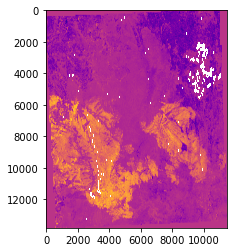

In [15]:
show(mosaic, cmap='plasma')

In [16]:
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": "+proj=utm +zone=55 +ellps=WGS84 +units=m +no_defs "})

In [17]:
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)